# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

## Nombres: Freddy Silva, César Cruz, Fernando Guevara, Kailin Wu
## Matrículas: A00828792, A00825747, A00828723, A00830574

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline


In [2]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/asl_data/'
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))

In [3]:
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Import Images

In [4]:
y_train = np.array(train_df['label'])
y_val = np.array(valid_df['label'])
del train_df['label']
del valid_df['label']
x_train = train_df.values.astype(np.float32)
x_val = valid_df.values.astype(np.float32)

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    Create a function that will allow you to split the previously loaded validation set
    into valition and test.

    Parameters:
        - x: Array of feature data.
        - y: Array of target labels corresponding to x.
        - pct: Proportion of data to allocate to the test set.
        - shuffle: Whether to randomly shuffle the data before spitting.

    Returns:
        - x_val, y_val: Validation features and labels
        - x_test, y_test: Test features and labels
    '''

    # Total number of samples in the dataset
    n = len(x)

    # Create an array of indices from 0 to n-1
    idx = np.arange(n)

    # Shuffle indices randomly if shuffle=True, this ensures the split is random.
    if shuffle:
        np.random.shuffle(idx)

    # Determine the split point based on the percentage
    split = int(n * (1 - pct))

    # Indices for validation and test set
    val_idx = idx[:split]
    test_idx = idx[split:]

    # Select validation and test data using the indices
    x_val, y_val = x[val_idx], y[val_idx]
    x_test, y_test = x[test_idx], y[test_idx]

    # Return validation and test splits
    return x_val, y_val, x_test, y_test

In [6]:
# Apply function to split data into validation and test
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

In [7]:
### The following

alphabet=list(string.ascii_lowercase)
alphabet.remove('j')
alphabet.remove('z')
print(len(alphabet))

24


### Normalise

This section performs feature normalization on the dataset. Specifically, it applies Z-score normalization.

In [8]:
def normalise(x_mean, x_std, x_data):
    """
    Standardizes input data using Z-score normalization.

    Parameters:
        - x_mean: Mean value computed from the training data.
        - x_std: Standard deviation value computed from the training data.
        - x_data: Data to be normalized
    
    Returns:
        - Normalized version of x_data.
    """
    return (x_data - x_mean) / x_std

In [9]:
# Compute the mean and standard deviation of the training data.
x_mean = x_train.mean()
x_std = x_train.std()

# Normalize the training data using its own mean and std
x_train = normalise(x_mean, x_std, x_train)

# Normalize the validation and test data using the training mean and std
x_val = normalise(x_mean, x_std, x_val)
x_test = normalise(x_mean, x_std, x_test)

In [10]:
# Check that the training data is now standardized
x_train.mean(), x_train.std()

(np.float32(-1.5389283e-07), np.float32(1.0))

### Plot samples

This section is used to visually inspect a random sample from the test dataset to ensure that the images and their lables are correctly aligned after preprocessing.

In [11]:
def plot_number(image):
    """
    Displays a grayscale image of a sign language.

    Parameters:
        - image: Falttened image array
    
    Returns:
        - None
    """
    plt.figure(figsize=(5,5))
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.axis('off')
    plt.show()

In [12]:
# Contains the true labels of the test dataset.
y_test

array([14,  4, 20, ...,  1,  4,  5], shape=(3586,))

The sampled image represents a: 14


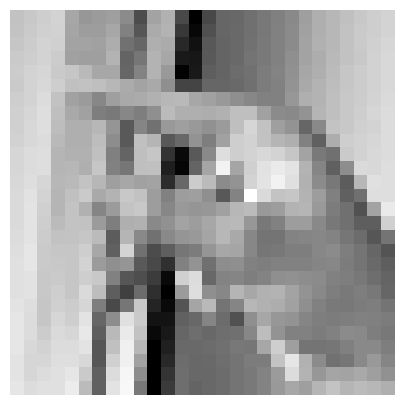

In [13]:
# Randomly select an index from the test set.
rnd_idx = np.random.randint(len(y_test))

# Print the true lable of the selected image
print(f'The sampled image represents a: {y_test[rnd_idx]}')

# Display the corresponding image
plot_number(x_test[rnd_idx])

### Equations for our model


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Additional functions

#### Mini batches

This function is responsible for splitting the dataset into mini-batches, which are small subsets of the data used during model training.

In [14]:
def create_minibatches(mb_size, x, y, shuffle = True):
    """
    Create mini-batches from the input dataset.

    Parameters:
        - mb_size: Size of each mini-batch.
        - x: Feature data.
        - y: Label data.
        - shuffle: Whether to randomly shuffle the data before creating mini-batches.
    
    Returns:
        - A generator that yields tuples (x_batch, y_batch),
        where each tuple corresponds to one mini-batch.
    """

    # Ensure that the number of samples in x and y is the same.
    assert x.shape[0] == y.shape[0]

    # Total number of samples.
    total_data = x.shape[0]

    # Shuffle the dataset if requested.
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]  

    # Generate mini-batches
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

## Lienar, ReLU and Sequential classes

In [15]:
# This class is serves as a semantic alias for numpy arrays
# that are intended to be used as tensors within a ML context.
class np_tensor(np.ndarray): pass

### Linear class

This class represents a fully connected neural network layer.

In [16]:
class Linear():
    """
    Fully connected layer.

    This class implements a linear transformation of the form:
        Z = W @ X + b
    
    where W and b are trainable parameters initialized using 
    Kaiming He initialization.
    """
    def __init__(self, input_size, output_size):
        """
        Initializes the parameters of the linear layer.

        Parameters:
            - input_size: Number of input features.
            - output_size: Number of output features.
        """

        # Weight matrix of shape
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)

        # Bias vector of shape
        self.b = (np.zeros((output_size, 1))).view(np_tensor)

    def __call__(self, X): 
        """
        Forward pass of the linear layer.

        Computes the linear transformation:
            Z = W @ X + b

        Parameters:
            - X: Input tensor of shape.

        Returns
            - Output tensor Z of shape.
        """
        Z = self.W @ X + self.b
        return Z
    
    def backward(self, X, Z):
        """
        Backward pass of the linear layer.

        Computes gradients of the loss with respect to the input X, the weights W,
        and the bias b.

        Parameters:
            - X: Input tensor used in the forward pass.
            - Z: Output tensor from the forward pass.

        Returns:
            None
        """

        # Gradient with respect to the input
        X.grad = self.W.T @ Z.grad

        # Gradient with respect to the weights
        self.W.grad = Z.grad @ X.T

        # Gradient with respect to the bias
        self.b.grad = np.sum(Z.grad, axis = 1, keepdims=True)    

### Clase ReLU
This class implements the ReLU activation function, which is one of the most widely used activation functions in neural networks.

In [17]:
class ReLU():
    """

    This class implements the ReLu activation:
        ReLU(Z) = max(0, Z)

    """
    def __call__(self, Z):
        """
        Foward pass of the ReLU activation. 
        
        Parameters:
            - Z: Input tensor.
        
        Returns:
            - Output tensor after applying ReLU.
        """
        return np.maximum(0, Z)
    
    def backward(self, Z, A):
        """
        Backward pass of the ReLU activation.

        Parameters:
            - Z: Input tensor to the ReLU during the forward pass.
            - A: Output tensor from the ReLU.
        
        Returns:
            - None
        """

        # Copy gradient from the next layer.
        Z.grad = A.grad.copy()
    
        # Zero out gradients where Z was inactive.
        Z.grad[Z <= 0] = 0

### Clase Sequential

This class works like a minimal version of Keras/PyTorch Sequential:
* You pass a list of layers: Lineas, ReLU, Linear, etc.
* It runs them in order during the forward pass.
* It stores intermediate outputs so it can do backpropagation.
* It updates parameters using gradient descent.

In [18]:
class Sequential_layers():
    """
    A simple sequential container for neural network layers.
    """

    def __init__(self, layers):
        """
        Initializes the sequential model.

        Parameters:
            - Layers: List of layer objects to be applied in sequence.
        """
        self.layers = layers
        self.x = None
        self.outputs = {}

    def __call__(self, X):
        """
        Forward pass through all layers.

        Parameters:
            - X: Input tensor of shape.

        Returns:
            - Output tensor after applying all layers.
        """
        self.x = X 

        # Store the input as the "output" of layer 0 
        self.outputs['l0'] = self.x

        # Apply each layer sequentially and store outputs
        for i, layer in enumerate(self.layers, 1):
            self.x = layer(self.x)
            self.outputs['l'+str(i)]=self.x

        return self.x
    
    def backward(self):
        """
        Backward pass through all layers.

        Returns:
            - None
        """

        # Iterate layers backwards
        for i in reversed(range(len(self.layers))):

            # For layer i, input is output of l{i}, output is outputs of l{i+1}
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])

    def update(self, learning_rate = 1e-3):
        """
        Updates trainable parameters using gradient descent.

        Parameters:
            - learning_rate: Step size for gradient descent updates.

        Returns:
            - None
        """

        for layer in self.layers:

            # Skip activation layers
            if isinstance(layer, ReLU): continue

            # Gradient descent update for Linear-like layers
            layer.W = layer.W - learning_rate * layer.W.grad
            layer.b = layer.b - learning_rate * layer.b.grad

    def predict(self, X):
        """
        Generates predictions from the model output.

        Parameters:
            - X: Input tensor.

        Returns:
            - Predicted class index based on argmax.
        """
        return np.argmax(self.__call__(X))        

### Cost Function

This section implements the Softmax + Cross-Entropy cost function, which is the standard loss function used for multi-class classification in neural networks.

In [19]:
def softmaxXEntropy(x, y):
    """
    Computes Softmax probabilities + Cross-Entropy loss, and sets the gradient dL/dx.

    Paramaters:
        - x: Raw class scores.
        - y: True class labels.
    
    Returns:
        - preds: Softmax probabilities.
        - cost: Mean cross-entropy loss over the batch.
    """

    # Number of samples in the batch
    batch_size = x.shape[1]

    # Convert logits to exponentialed scores
    exp_scores = np.exp(x)

    # Softmax probabilities per sample
    probs = exp_scores / exp_scores.sum(axis = 0)
    
    # Keep a copy of probabilities for output
    preds = probs.copy()
    
    # Cross-entropy loss
    # Extract the probability assigned to the correct class for each sample
    y_hat = probs[y.squeeze(), np.arange(batch_size)]

    # Compute mean negative log-likelihood
    cost = np.sum(-np.log(y_hat)) / batch_size
    
    # Gradient computation
    probs[y.squeeze(), np.arange(batch_size)] -= 1 #dl/dx
    x.grad = probs.copy()
    
    return preds, cost

### Training loop

This section implements the complete training and evaluation loop.

In [20]:
def train(model, epochs, mb_size=128, learning_rate = 1e-3):
    """
    Trains a neural network model using mini-batch gradient descent.

    Parameters:
        - model: Neural network model to be trained.
        - epochs: Number of full passes over the training dataset.
        - mb_size: Mini-batch size used during training.
        - learning_rate: Learning rate for gradient descent updates.

    Returns:
        - None
    """

    # Loop over epochs
    for epoch in range(epochs):

        # Iterates over training data in mini-batches
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):

            # Forward pass: compute class scores
            scores = model(x.T.view(np_tensor))

            # Compute loss and initialize gradient for backpropagation
            _, cost = softmaxXEntropy(scores, y)

            # Backward pass: propagate gradients through all layers
            model.backward()

            # Update model parameters using gradient descent
            model.update(learning_rate)

        # Evaluate and report validation accuracy after each epoch
        print(f'costo: {cost}, accuracy: {accuracy(x_val, y_val, mb_size)}')

In [21]:
def accuracy(x, y, mb_size):
    """
    Computes classification accuracy of the model.

    Parameters:
        - x: Input feature matrix.
        - y: True class labels.
        - mb_size: Mini-batch size used during evaluation.

    Returns:
        - Classification accuracy as a value between 0 and 1.
    """

    # Counter for correctly classified samples
    correct = 0

    # Counter for total evaluated samples
    total = 0

    # Iterate over the dataset in mini-batches
    for i, (x, y) in enumerate(create_minibatches(mb_size, x, y)):

        # Forward pass to obtain predictions
        pred = model(x.T.view(np_tensor))

        # Count correct predictions
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())

        # Update total number of samples
        total += pred.shape[1]
    
    # Return accuracy ratio
    return correct/total

### Create your model and train it

This section builds, trains, and evaluates a neural network classifier.

In [22]:
# Create a sequential neural network model
model = Sequential_layers([ Linear(784, 512), ReLU(), 
                            Linear(512, 128), ReLU(), 
                            Linear(128, 64), ReLU(), 
                            Linear(64, 28) ])

# Define training hyperparameters
mb_size = 512
learning_rate = 1e-4
epochs = 20

In [23]:
# Train the model using the defined training loop
train(model, epochs, mb_size, learning_rate)

costo: 1.2870168929000207, accuracy: 0.5814277746793084
costo: 0.3908086989948358, accuracy: 0.7163970998326826
costo: 0.23941253366077941, accuracy: 0.7462353597322923
costo: 0.12758716525890987, accuracy: 0.7532069157836029
costo: 0.07814419716937634, accuracy: 0.754601226993865
costo: 0.055947120121006326, accuracy: 0.7638036809815951
costo: 0.04016799931296291, accuracy: 0.7668711656441718
costo: 0.03086098399278095, accuracy: 0.7635248187395427
costo: 0.032492468238762076, accuracy: 0.7621305075292806
costo: 0.019870949591124485, accuracy: 0.7640825432236475
costo: 0.01679410475903677, accuracy: 0.7635248187395427
costo: 0.01486827080405695, accuracy: 0.7657557166759621
costo: 0.01441218299445588, accuracy: 0.7654768544339097
costo: 0.011609586334567996, accuracy: 0.7665923034021194
costo: 0.010394919939921126, accuracy: 0.7679866146123815
costo: 0.00843407667215948, accuracy: 0.7677077523703291
costo: 0.009560967040871334, accuracy: 0.7702175125488009
costo: 0.008111319496732536,

In [24]:
# Evaluate final model performance on the test dataset
print(accuracy(x_test, y_test, mb_size))

0.7780256553262688


#### Architecture and Hyperparameter Justification

A fully connected neural network (MLP) is used for a multiclass classification task based on vectorized images. The input size of **784** corresponds to flattened **28×28 pixel** images.

The architecture follows a **decreasing pyramidal structure**  
(784 → 512 → 128 → 64 → 28), whose goal is to learn increasingly abstract and compact representations while progressively reducing dimensionality to improve generalization and prevent overfitting. The wide initial layer enables the model to capture complex nonlinear interactions between pixels, while deeper layers consolidate these learned features.

The **ReLU** activation function is applied after each hidden layer due to its computational efficiency, its ability to mitigate the *vanishing gradient* problem, and its strong performance in deep networks.

The output layer contains **28 neurons**, corresponding to the number of classes. No explicit activation function is applied, as normalization is handled within the loss function (e.g., *Softmax + Cross-Entropy*).

Regarding hyperparameters, a **minibatch size of 512** is used to obtain stable gradient estimates and efficient training. A **learning rate of 1e-4** allows for controlled and stable convergence, while **20 epochs** represent a reasonable balance between performance and computational cost.


### Test your model on Random data from your test set

This section performs a qualitative evaluation of the trained model by testing it on a randomly selected sample from the test dataset.

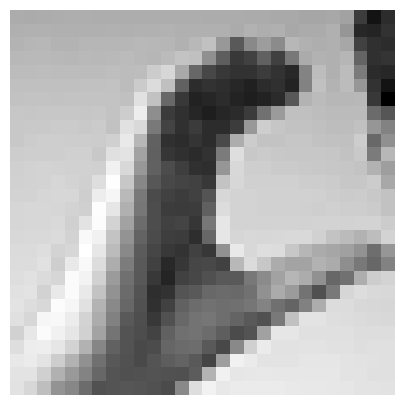

The predicted value is: c the true value is:c


In [25]:
# Select a random index from the test set
idx = np.random.randint(len(y_test))

# Plot the corresponding test image
plot_number(x_test[idx].reshape(28,28))

# Predict the class for the selected test sample
pred = model.predict(x_test[idx].reshape(-1, 1))

# Print the predicted label and true label
print(f'The predicted value is: {alphabet[pred]} the true value is:{alphabet[y_test[idx]]}')

### Conclusion

In this notebook, a neural network was built **from scratch using only NumPy**, without relying on high-level deep learning frameworks. Core components such as a `Sequential` container, `Linear` layers, and the `ReLU` activation function were manually implemented, enabling full control over the forward and backward propagation processes.

Using these building blocks, a multilayer architecture was designed and trained to learn hierarchical representations of the **ASL image dataset**, effectively decomposing the input images into progressively more abstract features. Despite the simplicity of the implementation and the absence of optimized libraries, the model achieved an accuracy above **70%**, approaching **80%**, demonstrating solid learning capacity.

Overall, this exercise reinforces a deeper understanding of how neural networks operate internally, including parameter initialization, gradient flow, and optimization dynamics. Implementing these components from the ground up provides valuable insight into the fundamental mechanics that underlie modern deep learning frameworks.
